In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [30]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset)

68

In [12]:
68*32

2176

In [14]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0]


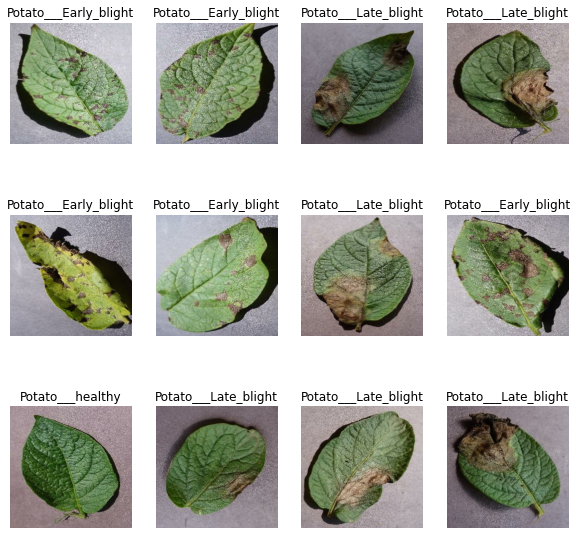

In [29]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
80% ==> train
20% ==> 10% ==> validation, 10% ==> test

In [31]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [32]:
train_ds = dataset.take(54)
len(train_ds)

54

In [33]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [34]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [35]:
val_ds = test_ds.take(6)

In [36]:
len(val_ds)

6

In [37]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [38]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [39]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [40]:
len(train_ds)

54

In [41]:
len(val_ds)

6

In [42]:
len(test_ds)

8

In [43]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)     # all this is to improve the performacne
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)    
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)     

In [44]:
# lets do some preprocessing

In [46]:
'''
These layers are for preprocessing and we will use it later while model building. One is to resize the image and other divides
the size of 256 by 255 to get a number between 0 and 1
'''
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [47]:
'''
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.
'''
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [48]:
# model building

In [49]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [52]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 80s 1s/step - loss: 0.9335 - accuracy: 0.4688 - val_loss: 0.8971 - val_accuracy: 0.4635
Epoch 2/50
54/54 [==============================] - 74s 1s/step - loss: 0.8024 - accuracy: 0.5943 - val_loss: 0.6006 - val_accuracy: 0.7344
Epoch 3/50
54/54 [==============================] - 73s 1s/step - loss: 0.5008 - accuracy: 0.7587 - val_loss: 0.3471 - val_accuracy: 0.8438
Epoch 4/50
54/54 [==============================] - 75s 1s/step - loss: 0.4018 - accuracy: 0.8247 - val_loss: 0.3803 - val_accuracy: 0.8281
Epoch 5/50
54/54 [==============================] - 74s 1s/step - loss: 0.3201 - accuracy: 0.8721 - val_loss: 0.1849 - val_accuracy: 0.9271
Epoch 6/50
54/54 [==============================] - 74s 1s/step - loss: 0.2305 - accuracy: 0.9126 - val_loss: 0.1645 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 74s 1s/step - loss: 0.1958 - accuracy: 0.9236 - val_loss: 0.0976 - val_accuracy: 0.9688
Epoch 8/50
54/54 [==

In [53]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 371ms/step - loss: 0.0100 - accuracy: 0.9961


In [54]:
scores

[0.010031091049313545, 0.99609375]

In [55]:
history

In [56]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [57]:
history.history

{'loss': [0.9335212707519531,
  0.8024168610572815,
  0.5008153319358826,
  0.40181678533554077,
  0.32014957070350647,
  0.2305045872926712,
  0.19577492773532867,
  0.12054701894521713,
  0.07739173620939255,
  0.12465628981590271,
  0.13034865260124207,
  0.12377869337797165,
  0.03740347921848297,
  0.0421430729329586,
  0.06119225546717644,
  0.01680925115942955,
  0.04548579081892967,
  0.0177118182182312,
  0.13392822444438934,
  0.044737204909324646,
  0.008953399024903774,
  0.004744845908135176,
  0.045170146971940994,
  0.028924593701958656,
  0.15194150805473328,
  0.03736298903822899,
  0.006601158529520035,
  0.014129827730357647,
  0.004684016574174166,
  0.005267377942800522,
  0.0013006726512685418,
  0.000303559034364298,
  0.00015441569848917425,
  0.00012272034655325115,
  0.00010050419223261997,
  8.722455095266923e-05,
  7.259305857587606e-05,
  6.347100134007633e-05,
  5.6875316658988595e-05,
  4.924516542814672e-05,
  4.383643681649119e-05,
  3.9302321965806186e

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

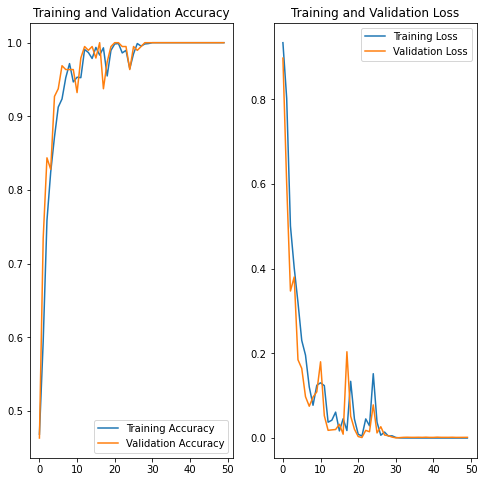

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


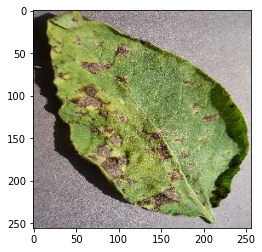

In [66]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [67]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

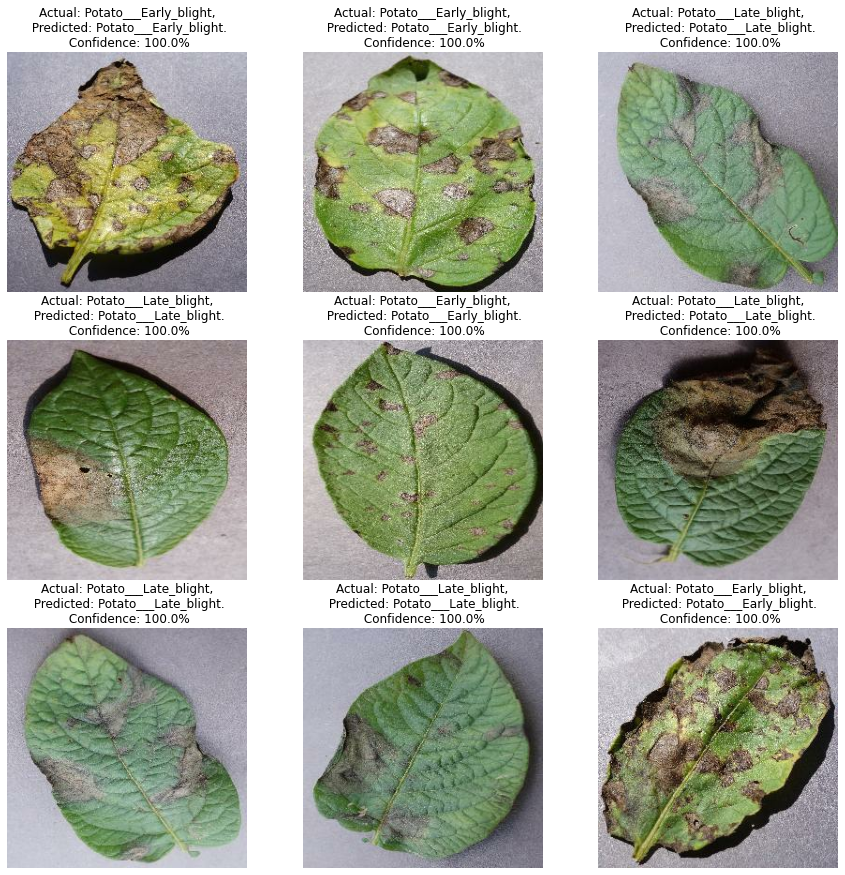

In [68]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [69]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


In [70]:
model.save("../potatoes.h5")